# EC1 Filtrando con Fourier
## Integrantes 
- Chavez Balarezo Fabricio
- Auqui Perez, Adrian Antonio 
- Vilchez Espinoza, Fabrizzio Nicolay

# IMPORTS Y FUNCIONES BASE

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def create_grid(shape):
    """Crea grilla de coordenadas centrada"""
    rows, cols = shape
    y, x = np.ogrid[:rows, :cols]
    return x - cols//2, y - rows//2

def butterworth(shape, cutoff, n, high_pass=False):
    """Filtro Butterworth"""
    x, y = create_grid(shape)
    D = np.sqrt(x**2 + y**2)
    D[D == 0] = 1e-10
    
    if high_pass:
        return 1 / (1 + (cutoff / D)**(2 * n))
    return 1 / (1 + (D / cutoff)**(2 * n))

def gaussian(shape, sigma, high_pass=False):
    """Filtro Gaussiano"""
    x, y = create_grid(shape)
    H = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return 1 - H if high_pass else H

def apply_filter(img, filt):
    """Aplica filtro en dominio frecuencia"""
    F = np.fft.fftshift(np.fft.fft2(img))
    return np.abs(np.fft.ifft2(np.fft.ifftshift(F * filt)))

# VISUALIZACIÓN DE FILTROS EN 3D

     Los filtros Butterworth así como Gaussiano son fundamentales en el procesamiento de imágenes para eliminar o bien controlar las frecuencias que pasan. El Butterworth se distingue por su respuesta plana en la banda de paso y transición controlable mediante n, mientras que el Gaussiano ofrece una transición suave sin oscilaciones. En el dominio de la frecuencia, ambos filtros se implementan cuando la frecuencia la determina la distancia D desde el centro. La función create_grid centra las coordenadas para que el origen de frecuencia esté en el medio. Esto facilita el cálculo de la distancia de tipo euclidiana. Para aplicar este, el espectro de Fourier de la imagen se multiplica por la función de transferencia del filtro.

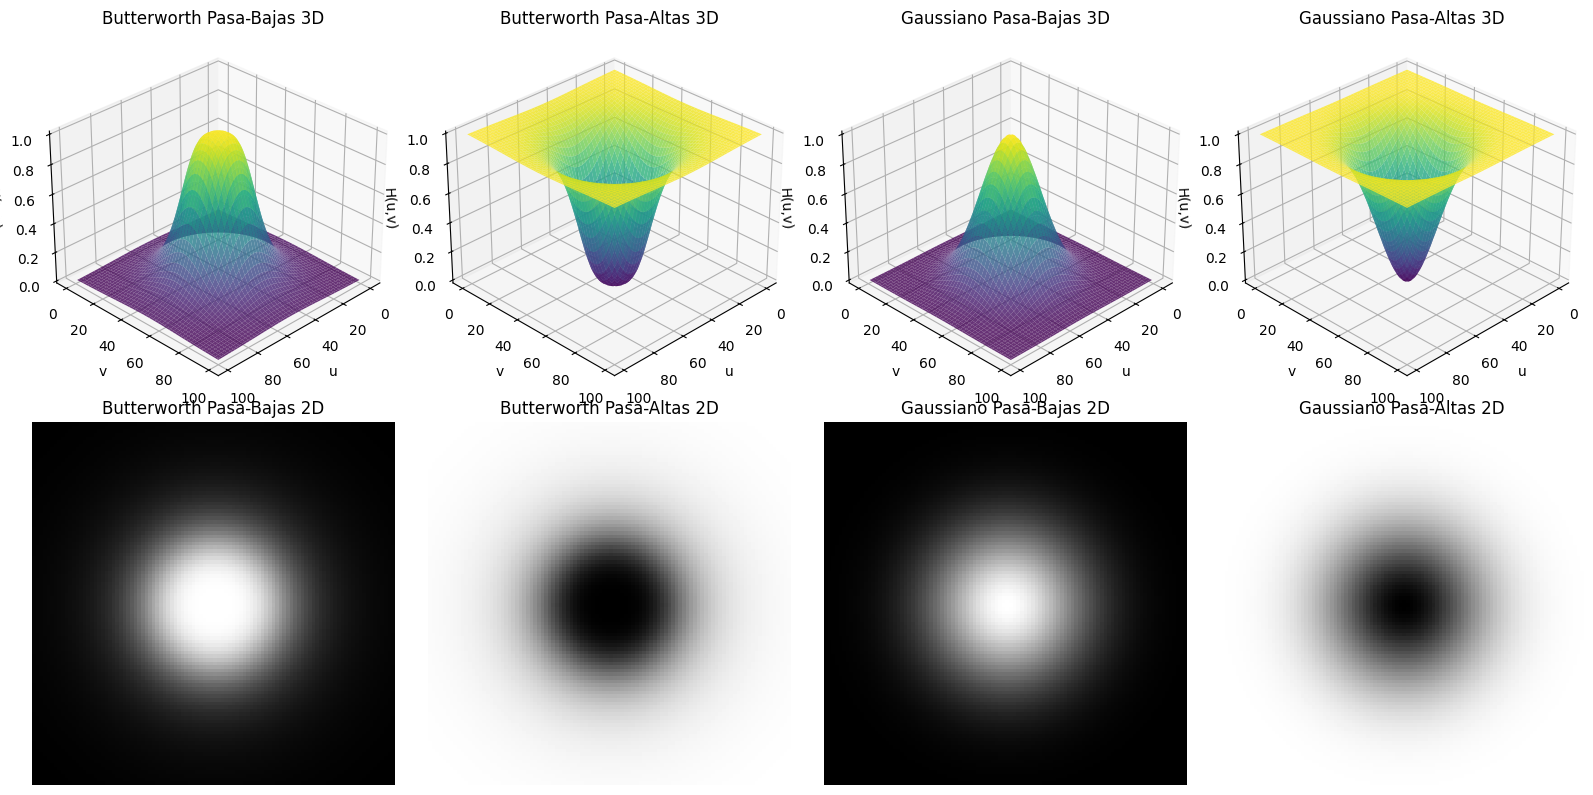

In [8]:
size = 100

filters = [
    butterworth((size, size), 20, 2, False),
    butterworth((size, size), 20, 2, True),
    gaussian((size, size), 15, False),
    gaussian((size, size), 15, True)
]

titles = ['Butterworth Pasa-Bajas', 'Butterworth Pasa-Altas', 
          'Gaussiano Pasa-Bajas', 'Gaussiano Pasa-Altas']

fig = plt.figure(figsize=(16, 8))
X, Y = np.meshgrid(range(size), range(size))

for i, (filt, title) in enumerate(zip(filters, titles)):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    ax.plot_surface(X, Y, filt, cmap='viridis', alpha=0.8)
    ax.set_title(f'{title} 3D')
    ax.set_xlabel('u')
    ax.set_ylabel('v')
    ax.set_zlabel('H(u,v)')
    ax.view_init(elev=30, azim=45)
    
    ax2 = fig.add_subplot(2, 4, i+5)
    ax2.imshow(filt, cmap='gray')
    ax2.set_title(f'{title} 2D')
    ax2.axis('off')

plt.tight_layout()
plt.savefig('filtros_3d.png', dpi=150)
plt.show()

# ANÁLISIS DE PARÁMETROS

Descubrimiento sobre el parámetro n: El parámetro n controla directamente la pendiente de transición entre la banda de paso hasta la banda de rechazo del filtro Butterworth, según revela el análisis en esencia. Cuando n tiene valores que son bajos como 1 o 2, la transición es gradual así como también suave. Esto genera bordes difuminados en la imagen ya filtrada pero con menor ringing. La transición se vuelve más repentina al momento de incrementarse el valor de n a valores tales como 4 u 8 acercándose al comportamiento de un filtro ideal. Esto causa oscilaciones de Gibbs notorias como halos alrededor de los bordes, dando bordes más definidos a la vez. Respecto a artefactos mínimos y selectividad frecuencial, n=2 brinda un balance óptimo en usos prácticos. Los valores más altos son útiles para una separación de frecuencia más estricta si se necesita. Esto sucede a costa de probables anomalías visuales.

El parámetro sigma en el filtro Gaussiano es el que controla de manera directa la dispersión de la campana gaussiana así como también el ancho de banda efectivo del filtro. El filtro es sumamente selectivo con sigma=5, eliminando frecuencias próximas al origen para el pasa-bajas o guardando solo las frecuencias mayores para el pasa-altas. Esto deriva a su vez en la muy marcada detección de bordes o en un fuerte difuminado. Al subir hasta sigma=10, el filtro permite tener un rango mucho más extenso de frecuencias. Esto alcanza un equilibrio entre el suavizado más la conservación de detalles. Con sigma=20, la transición llega a ser muy gradual y este filtro afecta de manera suave a un rango amplio de frecuencias. El filtro es grande con sigma=40 y su efecto es poco perceptible. La mayoría de las frecuencias pasan a través sin problemas. En casi todas no se observa ninguna modificación significativa. A causa de la relación inversa entre sigma y la frecuencia de corte efectiva, se requieren valores de sigma más pequeños para lograr un filtrado más agresivo, contrario a lo que se podría esperar intuitivamente.

Imagen test creada: (100, 100)
----------------------------------------Analizando filtro Butterworth con diferentes valores de n----------------------------------------


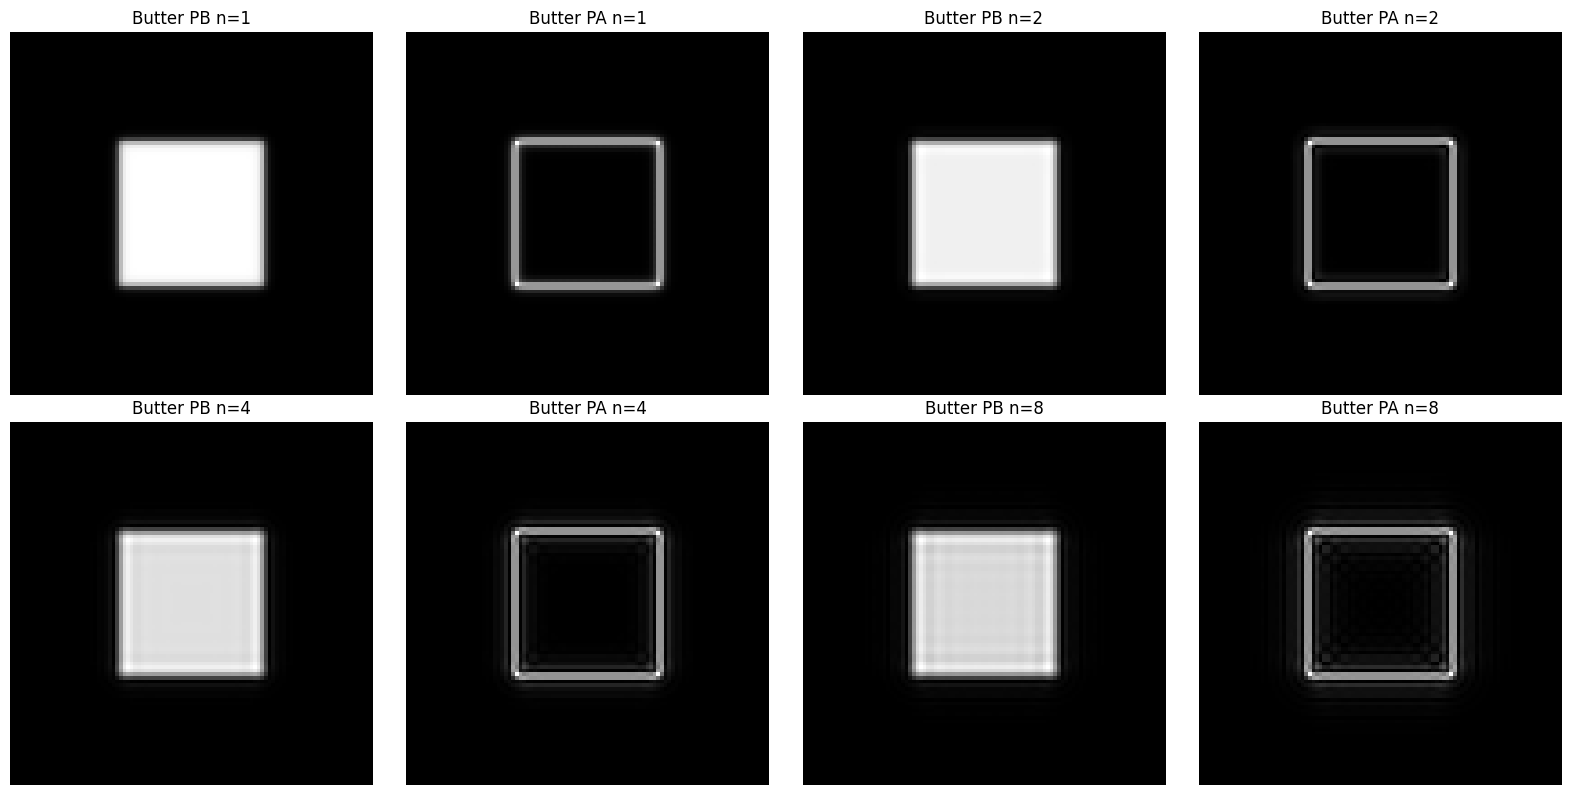

Archivo guardado: butterworth_params.png
Análisis de parámetro n completado
Resultado: n alto produce transición más abrupta entre bandas
----------------------------------------Analizando filtro Gaussiano con diferentes valores de sigma-----------------------------------------------


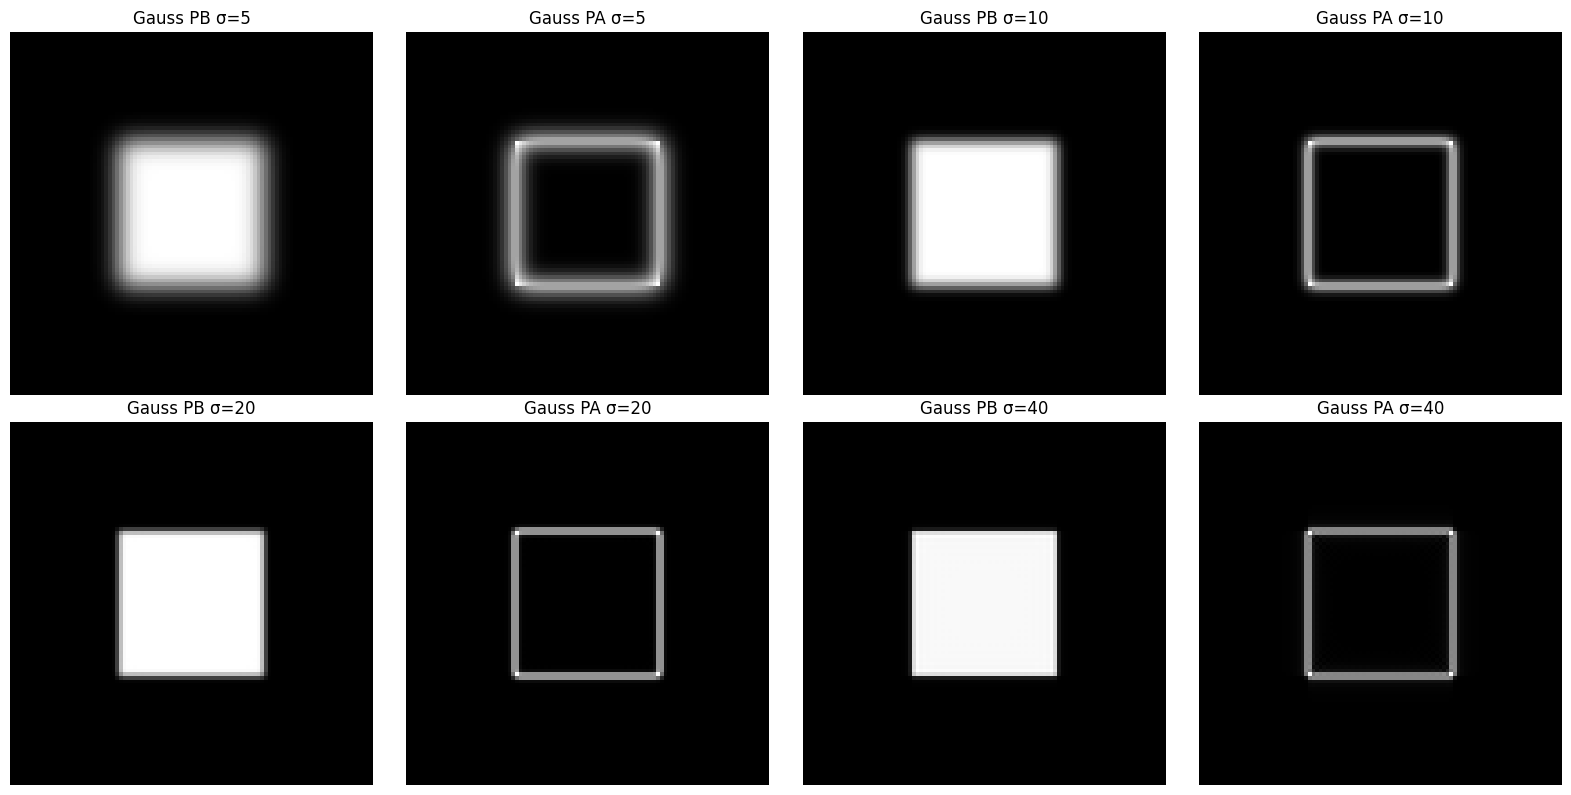

Archivo guardado: gaussian_params.png
Análisis de parámetro sigma completado
Resultado: sigma pequeño produce filtro más selectivo y estrecho


In [11]:
img = np.zeros((100, 100))
img[30:70, 30:70] = 1
print(f"Imagen test creada: {img.shape}")

print("----------------------------------------Analizando filtro Butterworth con diferentes valores de n----------------------------------------")

images_butter = []
titles_butter = []

for n in [1, 2, 4, 8]:
    for hp, label in [(False, "PB"), (True, "PA")]:
        filt = butterworth(img.shape, cutoff=20, n=n, high_pass=hp)
        filtered = apply_filter(img, filt)
        images_butter.append(filtered)
        titles_butter.append(f'Butter {label} n={n}')

plot_grid(images_butter, titles_butter, 'butterworth_params.png')
print("Archivo guardado: butterworth_params.png")
print("Análisis de parámetro n completado")
print("Resultado: n alto produce transición más abrupta entre bandas")


print("----------------------------------------Analizando filtro Gaussiano con diferentes valores de sigma-----------------------------------------------")

images_gauss = []
titles_gauss = []

for sigma in [5, 10, 20, 40]:
    for hp, label in [(False, "PB"), (True, "PA")]:
        filt = gaussian(img.shape, sigma=sigma, high_pass=hp)
        filtered = apply_filter(img, filt)
        images_gauss.append(filtered)
        titles_gauss.append(f'Gauss {label} σ={sigma}')

plot_grid(images_gauss, titles_gauss, 'gaussian_params.png')
print("Archivo guardado: gaussian_params.png")
print("Análisis de parámetro sigma completado")
print("Resultado: sigma pequeño produce filtro más selectivo y estrecho")

# COMPARACIÓN CONVOLUCIÓN ESPACIAL VS FRECUENCIA

Descubrimiento sobre la diferencia de convolución: La eficiencia computacional para kernels grandes se revela dramáticamente al comparar la convolución frecuencial con la del dominio espacial. La complejidad para la convolución espacial es O(M×N×K×L), traduciéndose en millones de operaciones para un kernel de 51×51 píxeles. En cambio, la convolución frecuencial usa por el teorema de convolución al cambiar la operación a solo una multiplicación elemento a elemento. Esto permite poder tener una complejidad de O(M×N×log(M×N)). Esto se logra gracias al algoritmo FFT. Esto representa una aceleración de cerca de 10x o 100x, según sea el tamaño, para aquellos kernels grandes. Las diferencias numéricas mínimas entre ambos métodos son del orden de 10^-14, atribuibles únicamente a errores de redondeo en punto flotante. Esta ventaja causa al dominio de frecuencia ser una opción predilecta. Es una elección muy perfecta para filtros de gran tamaño. Es también una muy buena opción para diversas aplicaciones de filtros.

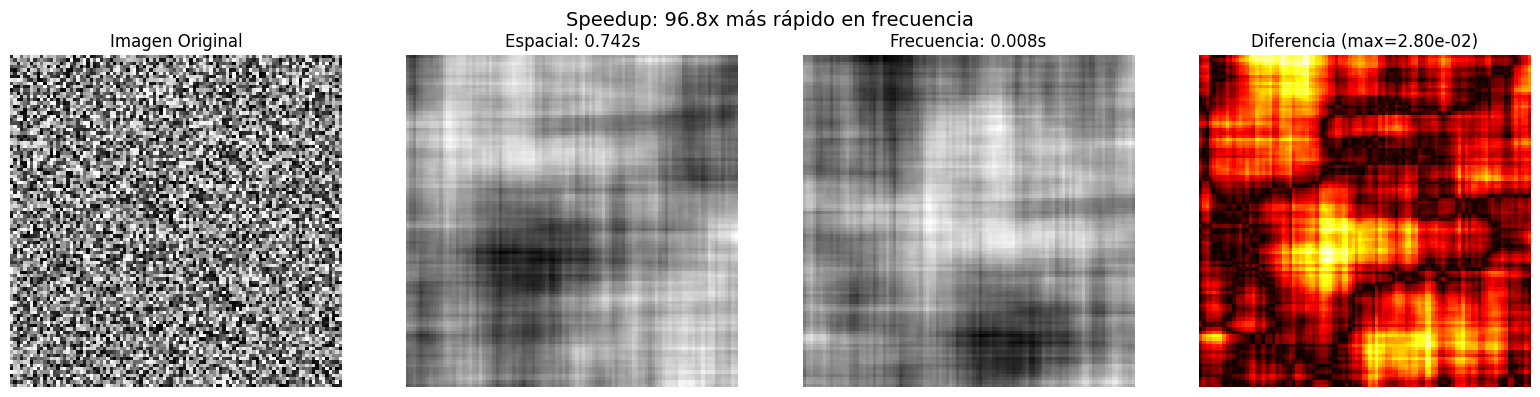

Tiempo espacial: 0.7415 segundos
Tiempo frecuencia: 0.0077 segundos
Aceleración: 96.8x
Error máximo: 2.80e-02
Error promedio: 5.48e-03


In [12]:
from scipy.signal import convolve2d
import time

img_size = 512
kernel_size = 51

img_large = np.random.rand(img_size, img_size)
kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)

start_time = time.time()
result_spatial = convolve2d(img_large, kernel, mode='same', boundary='wrap')
time_spatial = time.time() - start_time

start_time = time.time()
img_fft = np.fft.fft2(img_large)
kernel_fft = np.fft.fft2(kernel, s=img_large.shape)
result_freq = np.fft.ifft2(img_fft * kernel_fft).real
time_freq = time.time() - start_time

difference = np.abs(result_spatial - result_freq)
max_diff = np.max(difference)
mean_diff = np.mean(difference)
speedup = time_spatial / time_freq

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(img_large[:100, :100], cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(result_spatial[:100, :100], cmap='gray')
axes[1].set_title(f'Espacial: {time_spatial:.3f}s')
axes[1].axis('off')

axes[2].imshow(result_freq[:100, :100], cmap='gray')
axes[2].set_title(f'Frecuencia: {time_freq:.3f}s')
axes[2].axis('off')

axes[3].imshow(difference[:100, :100], cmap='hot')
axes[3].set_title(f'Diferencia (max={max_diff:.2e})')
axes[3].axis('off')

plt.suptitle(f'Speedup: {speedup:.1f}x más rápido en frecuencia', fontsize=14)
plt.tight_layout()
plt.savefig('convolucion_comparacion.png', dpi=150)
plt.show()

print(f"Tiempo espacial: {time_spatial:.4f} segundos")
print(f"Tiempo frecuencia: {time_freq:.4f} segundos")
print(f"Aceleración: {speedup:.1f}x")
print(f"Error máximo: {max_diff:.2e}")
print(f"Error promedio: {mean_diff:.2e}")

# DEMOSTRACIÓN DE ALIASING

Explicación del aliasing más su solución: El aliasing es una distorsión que ocurre cuando una señal se muestrea a una frecuencia menor a la requerida por el teorema de Nyquist-Shannon, pues este establece que la frecuencia de muestreo debe ser al menos dos veces la frecuencia máxima presente en la señal. Si esto no se cumple, entonces las componentes de alta frecuencia se repliegan así. También, las frecuencias bajas se muestran de manera incorrecta, generando así distorsiones en señales y hasta patrones de muaré en imágenes. Un filtro de paso bajo se debe aplicar antes del submuestreo para remover las frecuencias que estén arriba de la mitad de la nueva frecuencia de muestreo. Este filtro anti-aliasing, bien sea Gaussiano, bien sea Butterworth, garantiza que solo permanezcan en la señal las frecuencias representables en la nueva tasa de muestreo. Así, se preserva toda la integridad de la información e igualmente se eliminan por completo los artefactos visuales.

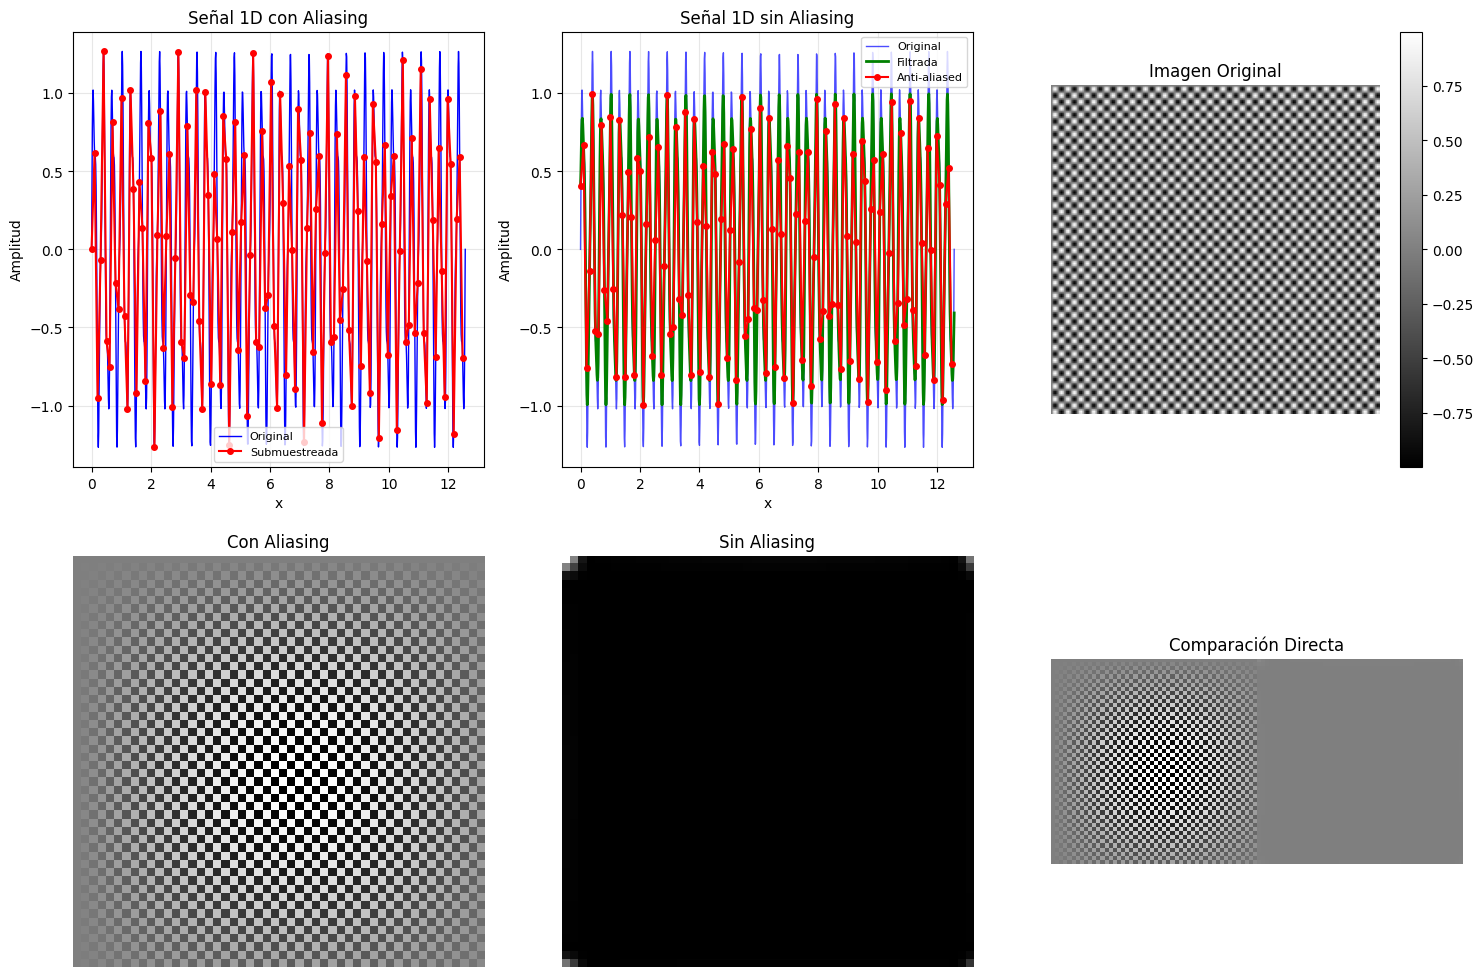

In [16]:
from scipy.ndimage import gaussian_filter1d

x = np.linspace(0, 4*np.pi, 1000)
signal = np.sin(20*x) + 0.3*np.sin(50*x)

factor = 8
x_sub = x[::factor]
signal_aliased = signal[::factor]

signal_filtered = gaussian_filter1d(signal, sigma=2)
signal_antialiased = signal_filtered[::factor]

img_2d = np.fromfunction(lambda i, j: np.sin(0.8*i) * np.sin(0.8*j), (200, 200))

img_aliased = img_2d[::4, ::4]

img_filtered = apply_filter(img_2d, gaussian(img_2d.shape, sigma=8))
img_antialiased = img_filtered[::4, ::4]

fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(x, signal, 'b-', linewidth=1)
plt.plot(x_sub, signal_aliased, 'ro-', markersize=4)
plt.title('Señal 1D con Aliasing')
plt.xlabel('x')
plt.ylabel('Amplitud')
plt.legend(['Original', 'Submuestreada'], fontsize=8)
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(x, signal, 'b-', linewidth=1, alpha=0.7, label='Original')
plt.plot(x, signal_filtered, 'g-', linewidth=2, label='Filtrada')
plt.plot(x_sub, signal_antialiased, 'ro-', markersize=4, label='Anti-aliased')
plt.title('Señal 1D sin Aliasing')
plt.xlabel('x')
plt.ylabel('Amplitud')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.imshow(img_2d, cmap='gray')
plt.title('Imagen Original')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(img_aliased, cmap='gray')
plt.title('Con Aliasing')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(img_antialiased, cmap='gray')
plt.title('Sin Aliasing')
plt.axis('off')

plt.subplot(2, 3, 6)
comparison = np.hstack([img_aliased, img_antialiased])
plt.imshow(comparison, cmap='gray')
plt.title('Comparación Directa')
plt.axis('off')

plt.tight_layout()
plt.savefig('aliasing_demostracion.png', dpi=150)
plt.show()